In [1]:
import pandas as pd

In [35]:
import os
from os import chdir as cd
cd ("/home/jacquin/Documents/DATA_SCIENCE/COMPETITION/VALEO/")

In [2]:
df1 = pd.read_csv("Train_Inputs.csv",sep=";")

In [3]:
df1.head()

,images,Unnamed: 1,Unnamed: 2
0,AE00474_105028_00_4_3_2001.jpg,NaN,NaN
1,AE00305_043057_00_2_4_2001.jpg,NaN,NaN
2,AE00191_071651_00_2_2_2001.jpg,NaN,NaN
3,AE00191_103659_00_2_1_2001.jpg,NaN,NaN
4,AE00227_204647_00_3_4_2001.jpg,NaN,NaN


In [4]:
df1.describe()

,Unnamed: 1,Unnamed: 2
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [36]:
df2 = pd.read_csv("train_data_labels.csv")

In [37]:
df2.head()

,images,labels
0,AE00474_105028_00_4_3_2001.jpg,0
1,AE00305_043057_00_2_4_2001.jpg,1
2,AE00191_071651_00_2_2_2001.jpg,1
3,AE00191_103659_00_2_1_2001.jpg,1
4,AE00227_204647_00_3_4_2001.jpg,1


In [7]:
df2.describe()

,labels
count,10609.000000
mean,0.620417
std,0.485306
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
df2["labels"].value_counts(normalize=True)

1    0.620417
0    0.379583
Name: labels, dtype: float64

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

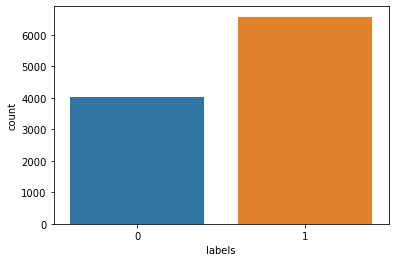

In [10]:
sns.countplot(df2["labels"]);

Nous avons presque le double de pièces deffectueuses non confirmées par l'opérateur

In [11]:
df3 = pd.read_csv("Y_Test_Inputs.csv")

In [12]:
df3.head()

,images
0,AE00022_095817_00_1_1_2001.jpg
1,AE00382_081204_00_3_4_2001.jpg
2,AE00281_235123_00_2_1_2001.jpg
3,AE00408_051313_00_4_4_2001.jpg
4,AE00379_034020_00_1_2_2001.jpg


In [13]:
df4 = pd.read_csv("Random_Submission.csv")

In [14]:
df4.head()

,images,labels
0,AE00022_095817_00_1_1_2001.jpg,0
1,AE00382_081204_00_3_4_2001.jpg,1
2,AE00281_235123_00_2_1_2001.jpg,0
3,AE00408_051313_00_4_4_2001.jpg,0
4,AE00379_034020_00_1_2_2001.jpg,0


DATA VIZ

In [15]:
cd ("/home/jacquin/Documents/DATA_SCIENCE/COMPETITION/VALEO/Data Challenge/Train_Dataset/")

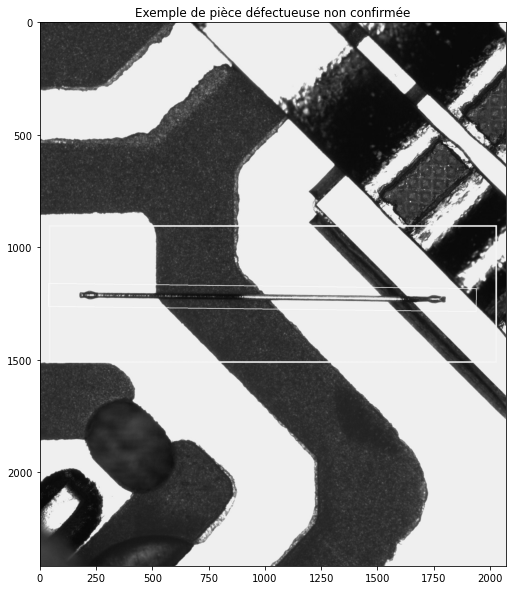

In [16]:
import cv2
plt.figure(figsize=(10,10))
plt.title ("Exemple de pièce défectueuse non confirmée")
img1 = cv2.imread("AE00305_043057_00_2_4_2001.jpg")
plt.imshow(img1);

In [17]:
img1.dtype

dtype('uint8')

In [18]:
img1.shape

(2415, 2070, 3)

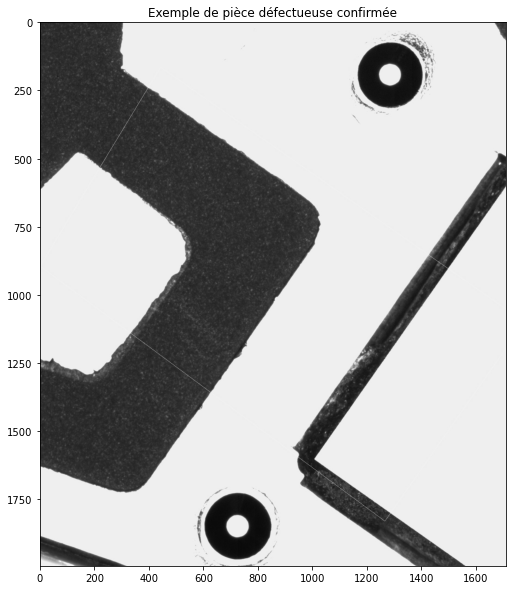

In [19]:
plt.figure(figsize=(10,10))
plt.title ("Exemple de pièce défectueuse confirmée")
img2 = cv2.imread("AE00474_105028_00_4_3_2001.jpg")
plt.imshow(img2);

In [20]:
img2.shape

(1995, 1710, 3)

SEPARATION DU JEU DE DONNÉES EN DONNÉES D'ENTRAINNEMENT ET DE TEST

In [38]:
from sklearn.model_selection import train_test_split
X_train_path, X_test_path, y_train, y_test = train_test_split(df2["images"], df2["labels"], test_size=0.2, random_state=123)

In [23]:
import tensorflow as tf
#cd ("/home/jacquin/Documents/DATA_SCIENCE/COMPETITION/VALEO/Data Challenge/Train_Dataset")
#X_test_path = df2["images"]
# Chargement des images de X_test_path redimensionnées à [256,256,3] en mémoire dans la variable X_test.
X_test = []
for filepath in X_test_path:
    # Read the file
    im = tf.io.read_file(filepath)
    # Decode the file
    im = tf.image.decode_jpeg(im, channels=3)
    # Resizing
    im = tf.image.resize(im, size=(256,256))
    X_test.append([im])
    
X_test = tf.concat(X_test, axis=0)

CREATION DU DATASET

In [24]:
def load_image(filepath, resize=(256,256)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels=3)
    return tf.image.resize(im, resize)

In [26]:
dataset_train =  tf.data.Dataset.from_tensor_slices((X_train_path, y_train))

In [27]:
dataset_train = dataset_train.map(lambda x, y : [load_image(x), y], num_parallel_calls=-1).batch(32)

MODELE VGG16

In [28]:
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam

In [29]:
# Définition du modèle
base_model = VGG16(weights='imagenet', include_top=False) 

n_class = 2 # 

# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

In [30]:
# Compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [31]:
# Définition des paramètres de sauvegarde
from tensorflow.keras import callbacks
# Sauvegarde des poids
checkpoint = callbacks.ModelCheckpoint(filepath="checkpoint",
                                      monitor="val_loss",
                                      save_best_only=True,
                                      save_weights_only=False,
                                      mode="min",
                                      save_freq="epoch")
lr_plateau = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                        patience=5,
                                        factor=0.1,
                                        verbose=2,
                                        monde="min")

In [32]:
# Entrainement du modèle
history = model.fit(dataset_train, epochs = 5, validation_data = (X_test, y_test), callbacks = [lr_plateau, checkpoint])

Epoch 1/5
266/266 [==============================] - ETA: 0s - loss: 0.3822 - acc: 0.9073 WARNING:tensorflow:From /home/jacquin/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/resource_variable_ops.py:1813: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoint/assets
266/266 [==============================] - 3308s 12s/step - loss: 0.3822 - acc: 0.9073 - val_loss: 0.1338 - val_acc: 0.9496 - lr: 0.0010
Epoch 2/5
266/266 [==============================] - 3308s 12s/step - loss: 0.1302 - acc: 0.9584 - val_loss: 0.1053 - val_acc: 0.9750 - lr: 0.0010
Epoch 3/5
266/266 [==============================] - 3301s 12s/step - loss: 0.0998 - acc: 0.9694 - val_loss: 0.0887 - val_acc: 0.9783 - lr: 0.0010
Epoch 4/5
266/266 [==============================] - 330

In [33]:
model.save("/home/jacquin/Documents/DATA_SCIENCE/COMPETITION/VALEO/Data Challenge/modelVGG16-2")

INFO:tensorflow:Assets written to: /home/jacquin/Documents/DATA_SCIENCE/COMPETITION/VALEO/Data Challenge/modelVGG16-2/assets


In [67]:
model.save("/home/jacquin/Documents/DATA_SCIENCE/COMPETITION/VALEO/Data Challenge/modelVGG16-2.h5")

In [69]:
model.save_weights("/home/jacquin/Documents/DATA_SCIENCE/COMPETITION/VALEO/Data Challenge/modelVGG16weights-2.h5")

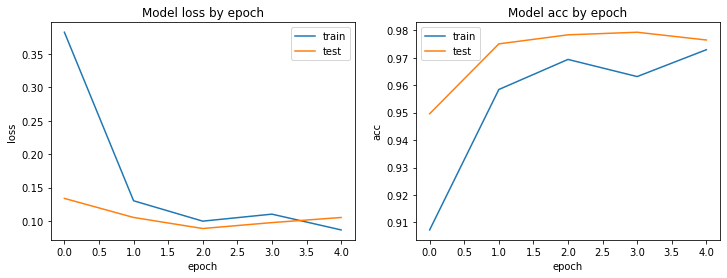

In [34]:
# Courbe de la fonction de coût et de précision en fonction de l'epoch.
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

POST-TRAITEMENT

In [35]:
# Calcul des probabilités
# On retourne pour chaque image une probabilité de prédiction de chaque classe.
y_prob = model.predict(X_test)

In [36]:
y_prob

array([[2.7759310e-03, 9.9722409e-01],
       [2.1177304e-03, 9.9788219e-01],
       [9.9999952e-01, 4.2140647e-07],
       ...,
       [1.8314816e-04, 9.9981683e-01],
       [3.4203671e-03, 9.9657959e-01],
       [9.9998045e-01, 1.9500651e-05]], dtype=float32)

In [40]:
# Pour prédire la classe de l'image, il suffit alors de trouver pour quelle classe la probabilité est maximale
y_pred = tf.argmax(y_prob, axis=-1).numpy()

In [41]:
y_pred

array([1, 1, 0, ..., 1, 1, 0])

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [44]:
print("accuracy", accuracy_score(y_test, y_pred))

accuracy 0.9764373232799246


In [45]:
confusion_matrix(y_test, y_pred)

array([[ 772,   48],
       [   2, 1300]])

In [5]:
C = (2+100*48)/(772+1300+2+48)

In [6]:
C

2.2629594721960413

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       820
           1       0.96      1.00      0.98      1302

    accuracy                           0.98      2122
   macro avg       0.98      0.97      0.97      2122
weighted avg       0.98      0.98      0.98      2122



In [49]:
indices_random = tf.random.uniform([4], 0, len(X_test), dtype=tf.int32)

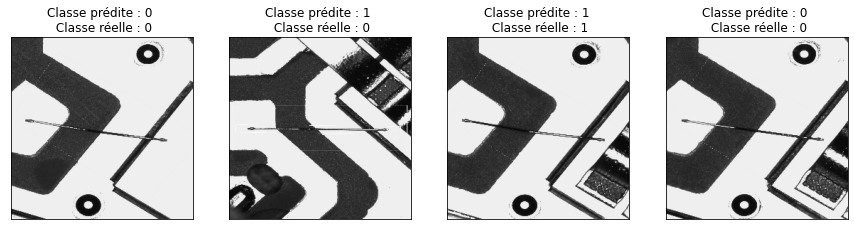

In [59]:
plt.figure(figsize=(15,15))
for i, idx in enumerate(indices_random):
    plt.subplot(1,4,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.xticks([])
    plt.yticks([])
    plt.title('Classe prédite : {} \n Classe réelle : {}'.format(df2["labels"].unique()[y_pred[idx]],
                                                                 df2["labels"].unique()[y_test.values[idx]]))

IMPORTATION DU MODELE

In [1]:
#Chargement du modèle
import keras
my_model = keras.models.load_model("/home/jacquin/Documents/DATA_SCIENCE/COMPETITION/VALEO/Data Challenge/modelVGG16-2")

In [8]:
import pandas as pd
test_dataset = pd.read_csv("Y_Test_Inputs.csv")

In [9]:
test_dataset.describe()

,images
count,1989
unique,1989
top,AE00346_062403_00_4_3_2001.jpg
freq,1


In [10]:
test_dataset.head()

,images
0,AE00022_095817_00_1_1_2001.jpg
1,AE00382_081204_00_3_4_2001.jpg
2,AE00281_235123_00_2_1_2001.jpg
3,AE00408_051313_00_4_4_2001.jpg
4,AE00379_034020_00_1_2_2001.jpg


In [17]:
# suppression du fichier manquant dans le tableau
test_dataset.drop(test_dataset.loc[test_dataset["images"] == "AE00072_145326_00_1_2_2001.jpg"].index, inplace=True)

In [18]:
# vérification
test_dataset[test_dataset["images"] == "AE00072_145326_00_1_2_2001.jpg"]

,images


In [20]:
test_dataset.describe()

,images
count,1988
unique,1988
top,AE00346_062403_00_4_3_2001.jpg
freq,1


In [21]:
import tensorflow as tf
import os
from os import chdir as cd
cd ("/home/jacquin/Documents/DATA_SCIENCE/COMPETITION/VALEO/Data Challenge/Test_Dataset")
# Chargement des images de X_test_path redimensionnées à [256,256,3] en mémoire dans la variable X_test.
X_test_path = test_dataset["images"]
X_test = []
for filepath in X_test_path:
    # Read the file
    im = tf.io.read_file(filepath)
    # Decode the file
    im = tf.image.decode_jpeg(im, channels=3)
    # Resizing
    im = tf.image.resize(im, size=(256,256))
    X_test.append([im])
    
X_test = tf.concat(X_test, axis=0)

In [22]:
len(X_test)

1988

In [24]:
# Calcul des probabilités
# On retourne pour chaque image une probabilité de prédiction de chaque classe.
y_prob = my_model.predict(X_test)

In [25]:
# Prédiction de la classe de l'image
y_pred = tf.argmax(y_prob, axis=-1).numpy()

Affichage de quelques images

In [42]:
indices_random = tf.random.uniform([4], 0, len(X_test), dtype=tf.int32)

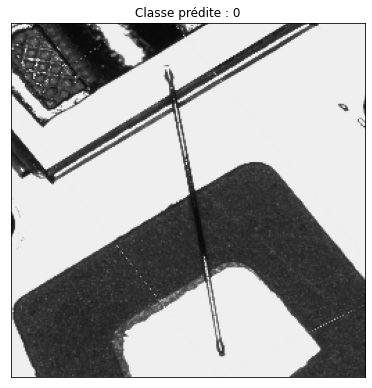

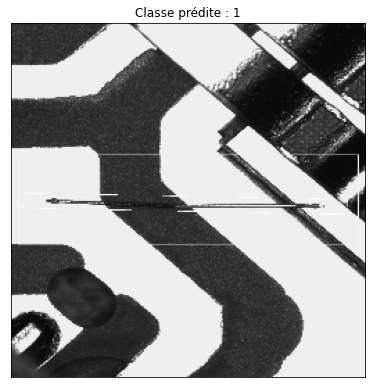

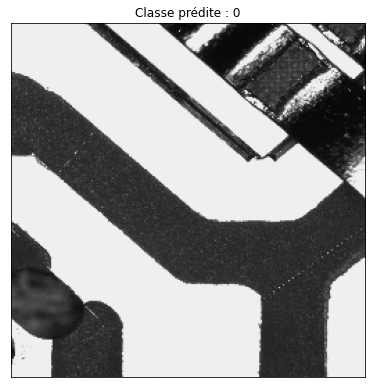

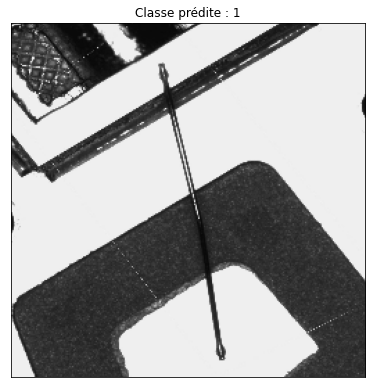

In [56]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(20,20))
for i, idx in enumerate(indices_random):
    plt.figure(figsize=(30,30))
    plt.subplot(4,1,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.xticks([])
    plt.yticks([])
    plt.title('Classe prédite : {}'.format(df2["labels"].unique()[y_pred[idx]]))  

In [57]:
test_dataset.head()

,images
0,AE00022_095817_00_1_1_2001.jpg
1,AE00382_081204_00_3_4_2001.jpg
2,AE00281_235123_00_2_1_2001.jpg
3,AE00408_051313_00_4_4_2001.jpg
4,AE00379_034020_00_1_2_2001.jpg


In [58]:
test_dataset["predicted_label"] = y_pred

In [59]:
test_dataset.head()

,images,predicted_label
0,AE00022_095817_00_1_1_2001.jpg,1
1,AE00382_081204_00_3_4_2001.jpg,1
2,AE00281_235123_00_2_1_2001.jpg,1
3,AE00408_051313_00_4_4_2001.jpg,0
4,AE00379_034020_00_1_2_2001.jpg,0


In [60]:
pwd

'/home/jacquin/Documents/DATA_SCIENCE/COMPETITION/VALEO'

In [63]:
test_dataset.to_csv("Y_test_submission.csv")